In [1]:
from typing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
results = pd.read_csv('../artifacts/csv-results/scaling-0sh/128b.csv')
results.rename(columns={results.columns[0]: 'task'}, inplace=True)
results.head()

,task,test_loss,test_conf_distribution_accuracy,test_conf_distribution_precision,test_conf_distribution_recall,test_conf_distribution_f1,test_conf_distribution_roc_auc,test_conf_distribution_bs,test_conf_distribution_bs_mcb,test_conf_distribution_bs_dsc,...,test_roc_auc,test_bs,test_bs_mcb,test_bs_dsc,test_bs_unc,test_balanced_accuracy,test_runtime,test_samples_per_second,test_steps_per_second,count
0,_total,0.514349,0.689279,0.58255,0.303154,0.398784,0.716353,0.195630,0.0,0.028746,...,0.782398,0.174274,0.002912,5.301398e-02,0.224376,0.686774,171.5190,63.083,7.888,10820
1,abstract_narrative_understanding,0.646189,0.663415,0.00000,0.000000,0.000000,0.500000,0.223296,0.0,0.000000,...,0.456628,0.226496,0.006892,3.691539e-03,0.223296,0.500000,2.8855,71.044,9.010,205
2,anachronisms,0.709275,0.543478,0.00000,0.000000,0.000000,0.500000,0.248110,0.0,0.000000,...,0.546667,0.258012,0.035146,2.524330e-02,0.248110,0.524762,0.6605,69.645,9.084,46
3,analogical_similarity,0.622962,0.723077,0.00000,0.000000,0.000000,0.500000,0.200237,0.0,0.000000,...,0.527778,0.210968,0.010732,-1.942890e-16,0.200237,0.500000,0.9439,68.866,9.535,65
4,analytic_entailment,0.639888,0.642857,0.00000,0.000000,0.000000,0.500000,0.229592,0.0,0.000000,...,0.733333,0.229189,0.086332,8.673470e-02,0.229592,0.566667,0.2262,61.885,8.841,14


/tmp/ipykernel_3231652/3800602700.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{}], ignore_index=True)
/tmp/ipykernel_3231652/3800602700.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(total)


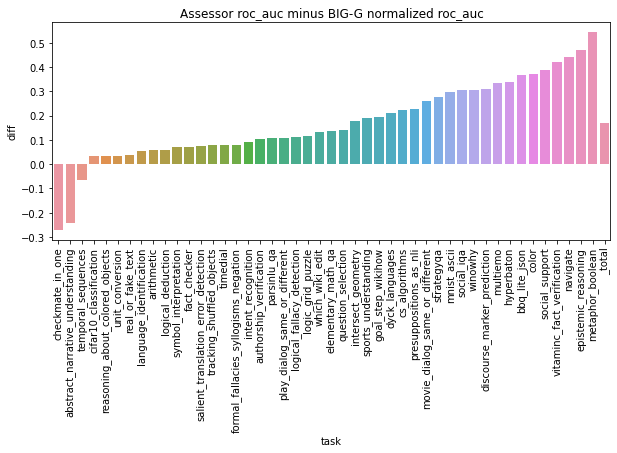

In [3]:
Baseline = Literal['normalized', 'absolute', 'distribution']

def plot(df: pd.DataFrame, baseline: Baseline = "normalized", metric: str = "roc_auc"):
    task_system_col = f"test_conf_{baseline}_{metric}"
    assessor_col = f"test_{metric}"

    data = df[[task_system_col, assessor_col, 'task', 'count']]
    data = data[df['test_conf_normalized_roc_auc'] > 0.1]
    data = data[data['count'] > 100]
    data['diff'] = data[assessor_col] - data[task_system_col]
    data.sort_values(by='diff', inplace=True)
    total = data[data['task'] == '_total']
    data = data[data['task'] != '_total']
    data = data.append([{}], ignore_index=True)
    data = data.append(total)

    plt.figure(figsize=(10,4))
    p = sns.barplot(x="task", y="diff", data=data) # orient='h')
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    p.set_title(f"Assessor {metric} minus BIG-G {baseline} {metric}")
    # for i in p.containers:
    #     p.bar_label(i,)

    # return data

# plot(results, metric="accuracy")
plot(results, metric="roc_auc", baseline="normalized")

47
<BarContainer object of 47 artists>


/tmp/ipykernel_3231652/1970348385.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(total)


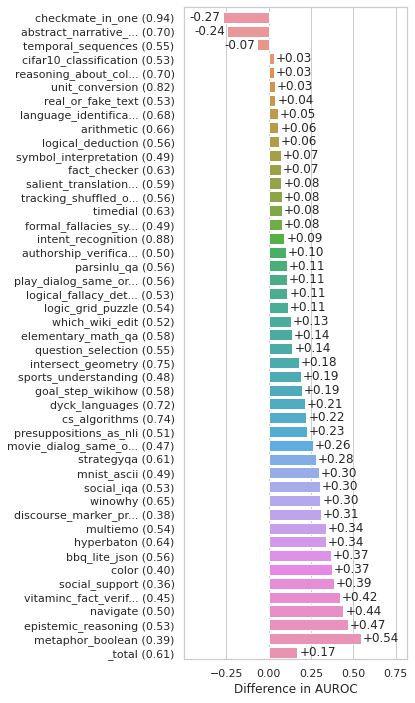

In [8]:
def shorten(x, length=15):
    if len(x) > length:
        return x[:length-3] + "..."
    else:
        return x

def plot2(df: pd.DataFrame, baseline: Baseline = "normalized", metric: str = "roc_auc"):
    sns.set_theme(style="whitegrid")
    task_system_col = f"test_conf_{baseline}_{metric}"
    assessor_col = f"test_{metric}"

    data = df[[task_system_col, assessor_col, 'task', 'count']]
    data = data[df['test_conf_normalized_roc_auc'] > 0.1]
    data = data[data['count'] > 100]
    data['diff'] = data[assessor_col] - data[task_system_col]
    data['task'] = data['task'].apply(lambda x: shorten(x, length=22))
    # data.loc[df['task'] == "formal_fallacies_syllogisms_negation", 'task'] = "formal_fallacies_syllogisms_neg."
    # data.loc[df['task'] == "salient_translation_error_detection", 'task'] = "salient_translation_error_detect."

    # Sorting and adding total
    data.sort_values(by='diff', inplace=True)
    print(len(data))
    total = data[data['task'] == '_total']
    data = data[data['task'] != '_total']
    # data = data.append([{}], ignore_index=True)
    data = data.append(total)

    plt.figure(figsize=(4,12))
    
    y = data.apply(lambda x: f"{x['task']} ({x[task_system_col]:.2f})", axis=1)
    p = sns.barplot(y=y, x="diff", data=data, orient='h')
    for i in p.containers:
        print(i)
        p.bar_label(i,fmt='%+.2f', label_type='edge', padding=2)
    p.set_xlim(p.get_xlim()[0]*1.6, p.get_xlim()[1]*1.4)
    p.set_ylim(p.get_ylim()[0]*1.0, p.get_ylim()[1]*1.5)

    # disable x-axis labels
    p.set_xlabel("Difference in AUROC")
    plt.savefig(f'../artifacts/plots/main.svg', bbox_inches='tight', format='svg')

# plot(results, metric="accuracy")
plot2(results, metric="roc_auc")